In [1]:
import json

import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
stim_df = pd.read_csv("../data/NSD/nsd_stim_info_merged.csv", index_col=0)
print(stim_df.shape)
print(stim_df.columns)
print(stim_df.iloc[:4, :10])

(73000, 40)
Index(['cocoId', 'cocoSplit', 'cropBox', 'loss', 'nsdId', 'flagged',
       'BOLD5000', 'shared1000', 'subject1', 'subject2', 'subject3',
       'subject4', 'subject5', 'subject6', 'subject7', 'subject8',
       'subject1_rep0', 'subject1_rep1', 'subject1_rep2', 'subject2_rep0',
       'subject2_rep1', 'subject2_rep2', 'subject3_rep0', 'subject3_rep1',
       'subject3_rep2', 'subject4_rep0', 'subject4_rep1', 'subject4_rep2',
       'subject5_rep0', 'subject5_rep1', 'subject5_rep2', 'subject6_rep0',
       'subject6_rep1', 'subject6_rep2', 'subject7_rep0', 'subject7_rep1',
       'subject7_rep2', 'subject8_rep0', 'subject8_rep1', 'subject8_rep2'],
      dtype='object')
   cocoId cocoSplit                         cropBox   loss  nsdId  flagged  \
0  532481   val2017    (0, 0, 0.1671875, 0.1671875)  0.100      0    False   
1  245764   val2017            (0, 0, 0.125, 0.125)  0.000      1    False   
2  385029   val2017            (0, 0, 0.125, 0.125)  0.000      2    False  

In [3]:
run_df = pd.read_parquet("../metadata/nsd_run_metadata.parquet")
print(run_df.shape)
run_df.head()

(3600, 4)


,sub,ses,run,n_trials
0,subj01,1,1,63
1,subj01,1,2,62
2,subj01,1,3,63
3,subj01,1,4,62
4,subj01,1,5,63


In [4]:
# subjects have diff num sessions, but no missing sessions
print(run_df.groupby("sub").agg({"ses": ["max", "nunique"]}))

       ses        
       max nunique
sub               
subj01  40      40
subj02  40      40
subj03  32      32
subj04  30      30
subj05  40      40
subj06  32      32
subj07  40      40
subj08  30      30


In [5]:
# runs have 63 (odd runs) or 62 trials (even runs)
# https://cvnlab.slite.page/p/fRv4lz5V2F/Behavioral-data
print(run_df["n_trials"].value_counts())

n_trials
63    1704
62    1704
0      192
Name: count, dtype: int64


In [6]:
trial_df = pd.read_parquet("../metadata/nsd_trial_metadata.parquet")
print(trial_df.shape)
trial_df.head()

(213000, 7)


,sub,ses,run,trial_id,onset,duration,nsd_id
0,subj01,1,1,0,12.0,3.0,46002
1,subj01,1,1,1,16.0,3.0,61882
2,subj01,1,1,2,20.0,3.0,828
3,subj01,1,1,3,24.0,3.0,67573
4,subj01,1,1,4,28.0,3.0,16020


In [7]:
# trial id is correct (nb stim df trial id is 1-indexed, 0 is not shown)
print(trial_df.iloc[123456].to_dict())
print(stim_df.loc[62146, ["subject5_rep1"]].item() - 1)

{'sub': 'subj05', 'ses': 23, 'run': 9, 'trial_id': 16956, 'onset': 88.0, 'duration': 3.0, 'nsd_id': 62146}
16956


In [8]:
# all images shown to only one sub, except shared1000 shown to all
print(trial_df.groupby("sub").agg({"nsd_id": ["count", "nunique"]}))
print(trial_df.groupby("nsd_id").agg({"sub": "nunique"}).value_counts())

       nsd_id        
        count nunique
sub                  
subj01  30000   10000
subj02  30000   10000
subj03  24000    9411
subj04  22500    9209
subj05  30000   10000
subj06  24000    9411
subj07  30000   10000
subj08  22500    9209
sub
1      69566
8        907
4         70
6         23
Name: count, dtype: int64


In [9]:
with open("../metadata/coco_categories.json") as f:
    coco_categories = json.load(f)
print(len(coco_categories))
print("\n".join(coco_categories[:10]))

80
person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light


In [10]:
logits = np.load("../data/nsd_clip_coco_logits.npy")
print(logits.shape)

(73000, 80)


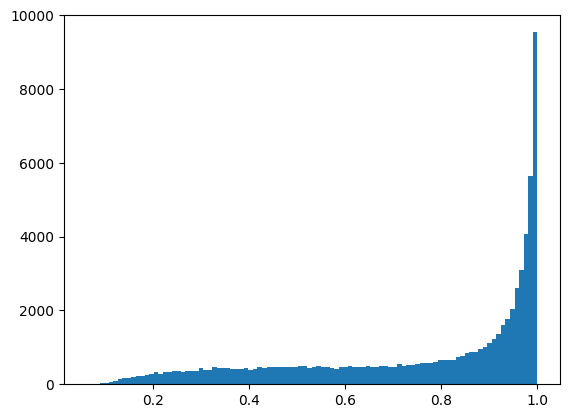

In [11]:
prob = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
targets = prob.argmax(axis=1)
conf = prob.max(axis=1)
plt.hist(conf, bins=100);

In [12]:
# only keep distinct images with high clip classification confidence
# and restrict to categories with enough distinct images
img_mask = conf > 0.9
uniq, counts = np.unique(targets[img_mask], return_counts=True)
sort_ids = np.argsort(-counts)
for ii, idx in enumerate(sort_ids):
    print(ii, coco_categories[uniq[idx]], counts[idx])

0 tennis racket 1688
1 giraffe 1659
2 surfboard 1499
3 skateboard 1493
4 train 1438
5 elephant 1427
6 bus 1264
7 zebra 1139
8 toilet 1105
9 pizza 1100
10 clock 1057
11 skis 1048
12 motorcycle 991
13 kite 940
14 airplane 834
15 sheep 833
16 umbrella 796
17 horse 748
18 cow 699
19 cake 690
20 bed 665
21 stop sign 660
22 fire hydrant 647
23 snowboard 618
24 bird 488
25 frisbee 480
26 teddy bear 444
27 banana 432
28 bench 430
29 donut 382
30 boat 381
31 suitcase 376
32 bear 369
33 truck 368
34 vase 340
35 traffic light 299
36 hot dog 275
37 broccoli 241
38 refrigerator 238
39 parking meter 221
40 dining table 216
41 oven 216
42 sandwich 212
43 baseball bat 205
44 tie 202
45 sink 170
46 orange 161
47 toothbrush 154
48 scissors 148
49 bicycle 137
50 apple 127
51 wine glass 86
52 baseball glove 81
53 couch 70
54 microwave 70
55 remote 70
56 carrot 67
57 laptop 60
58 sports ball 59
59 tv 55
60 cell phone 46
61 keyboard 46
62 hair drier 42
63 handbag 29
64 potted plant 24
65 mouse 18
66 backpac

In [13]:
cutoff = 600
include_label_ids = uniq[counts >= cutoff]
img_mask = img_mask & np.isin(targets, include_label_ids)

# also exclude shared1000
img_mask = img_mask & ~stim_df["shared1000"].values
print(include_label_ids)
print(len(include_label_ids), img_mask.sum())
print(", ".join(coco_categories[ii] for ii in include_label_ids))

with open("../metadata/nsd_include_coco_categories.json", "w") as f:
    print(
        json.dumps({coco_categories[ii]: ii for ii in include_label_ids.tolist()}, indent=4), file=f
    )

[ 3  4  5  6 10 11 17 18 19 20 22 23 25 30 31 33 36 37 38 53 55 59 61 74]
24 24653
motorcycle, airplane, bus, train, fire hydrant, stop sign, horse, sheep, cow, elephant, zebra, giraffe, umbrella, skis, snowboard, kite, skateboard, surfboard, tennis racket, pizza, cake, bed, toilet, clock


In [14]:
# now find all trials corresponding to included images
include_img_ids = np.flatnonzero(img_mask)
trial_mask = np.isin(trial_df["nsd_id"].values, include_img_ids)
# only include trials where previous trial is not included
run_ids = trial_df["run"].values
for ii in range(1, len(trial_df)):
    if trial_mask[ii - 1] and (run_ids[ii] == run_ids[ii - 1]):
        trial_mask[ii] = False

include_trial_ids = np.flatnonzero(trial_mask)

print(trial_mask.sum())
print(trial_df.loc[trial_mask].groupby("sub").size())
print(trial_df.loc[trial_mask].groupby("nsd_id").size().value_counts())

delays = np.diff(np.flatnonzero(trial_mask))
print(np.quantile(delays, [0.0, 0.01, 0.25, 0.5, 0.75, 0.99, 1.0]))

print(np.unique(targets[trial_df.loc[trial_mask, "nsd_id"].values]))

50340
sub
subj01    7054
subj02    7075
subj03    5540
subj04    5418
subj05    7196
subj06    5658
subj07    7055
subj08    5344
dtype: int64
2    9602
3    8823
1    4667
Name: count, dtype: int64
[ 1.  2.  2.  3.  5. 14. 33.]
[ 3  4  5  6 10 11 17 18 19 20 22 23 25 30 31 33 36 37 38 53 55 59 61 74]


In [15]:
np.save("../metadata/nsd_include_trial_ids.npy", include_trial_ids)